# Hospital Readmissions Data Analysis and Recommendations for Reduction

## Background

In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

In [126]:
%matplotlib inline
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from statsmodels.stats import weightstats as stests

In [6]:
hospital_read_df = pd.read_csv('cms_hospital_readmissions.csv')
hospital_read_df.head()

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,FROEDTERT MEMORIAL LUTHERAN HOSPITAL,520177,WI,READM-30-HIP-KNEE-HRRP,242,NaN,1.9095,10.8,5.6,38.0,07/01/2010,06/30/2013
1,PROVIDENCE HOSPITAL,90006,DC,READM-30-HIP-KNEE-HRRP,247,NaN,1.7521,9.2,5.3,33.0,07/01/2010,06/30/2013
2,BEAUFORT COUNTY MEMORIAL HOSPITAL,420067,SC,READM-30-HIP-KNEE-HRRP,586,NaN,1.5836,7.6,4.8,53.0,07/01/2010,06/30/2013
3,ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER,140208,IL,READM-30-HIP-KNEE-HRRP,965,NaN,1.5760,9.0,5.7,95.0,07/01/2010,06/30/2013
4,BRAZOSPORT REGIONAL HEALTH SYSTEM,450072,TX,READM-30-HIP-KNEE-HRRP,149,NaN,1.5308,8.2,5.4,20.0,07/01/2010,06/30/2013


## Preliminary Analysis

In [50]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


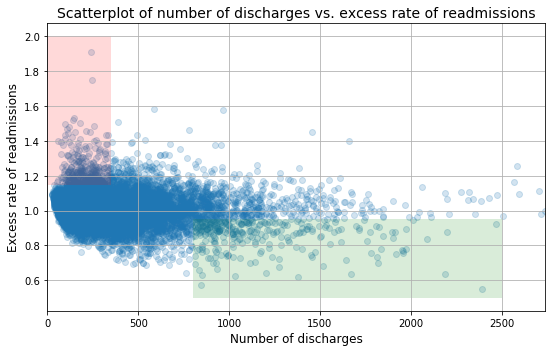

In [51]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

## Preliminary Report

    A. Initial observations based on the plot above

Overall, rate of readmissions is trending down with increasing number of discharges
With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green)

    B. Statistics 

In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1
In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1

    C. Conclusions

There is a significant correlation between hospital capacity (number of discharges) and readmission rates.
Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

    D. Regulatory policy recommendations

Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.





Report statistical significance for $\alpha$ = .01.
Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
Look at the scatterplot above.
What are the advantages and disadvantages of using this plot to convey information?
Construct another plot that conveys the same information in a more direct manner.
You can compose in notebook cells using Markdown:

In the control panel at the top, choose Cell > Cell Type > Markdown
Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

In [58]:
data=clean_hospital_read_df.dropna(subset=['Number of Readmissions'])
data.columns = data.columns.str.replace(' ', '')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11497 entries, 1832 to 13666
Data columns (total 12 columns):
HospitalName                11497 non-null object
ProviderNumber              11497 non-null int64
State                       11497 non-null object
MeasureName                 11497 non-null object
NumberofDischarges          11497 non-null int64
Footnote                    0 non-null float64
ExcessReadmissionRatio      11497 non-null float64
PredictedReadmissionRate    11497 non-null float64
ExpectedReadmissionRate     11497 non-null float64
NumberofReadmissions        11497 non-null float64
StartDate                   11497 non-null object
EndDate                     11497 non-null object
dtypes: float64(5), int64(2), object(5)
memory usage: 1.1+ MB


##  My Analysis

H0= There is a correlation between hospital capacity (number of discharges) and readmission rates.

H1= There isn't a correlation between hospital capacity (number of discharges) and readmission rates.

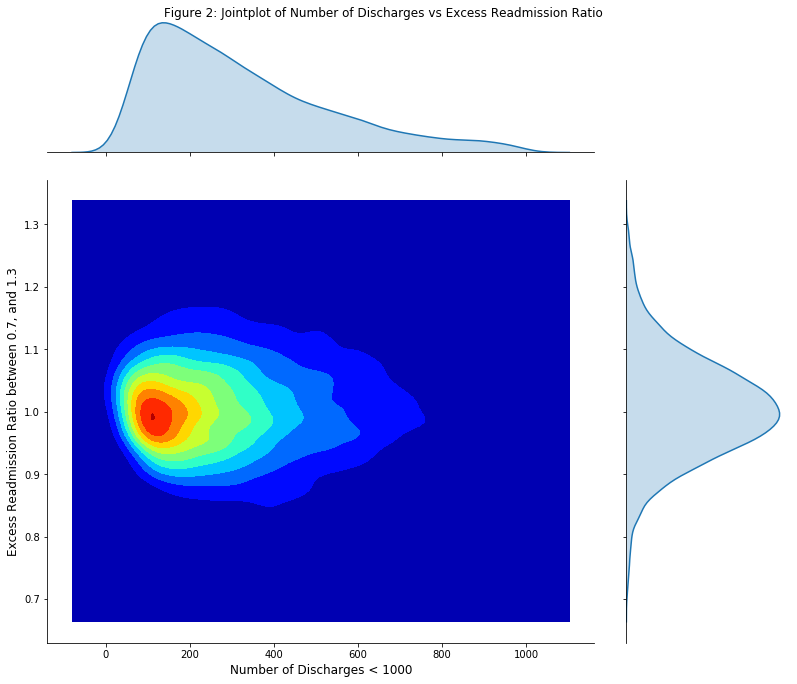

In [159]:
new=data.loc[data.NumberofDischarges<1000]
newer=new.loc[new.ExcessReadmissionRatio<1.3]
newest=newer.loc[newer.ExcessReadmissionRatio>0.7]
g=sns.jointplot(x='NumberofDischarges', y='ExcessReadmissionRatio', data=newest, kind="kde",cmap=cm.jet,
              n_levels=10,ratio=3)
g.fig.suptitle('Figure 2: Jointplot of Number of Discharges vs Excess Readmission Ratio')
g.set_axis_labels('Number of Discharges < 1000','Excess Readmission Ratio between 0.7, and 1.3' , fontsize=12)
fig = plt.gcf()
fig.set_size_inches( 12, 10)
plt.show()

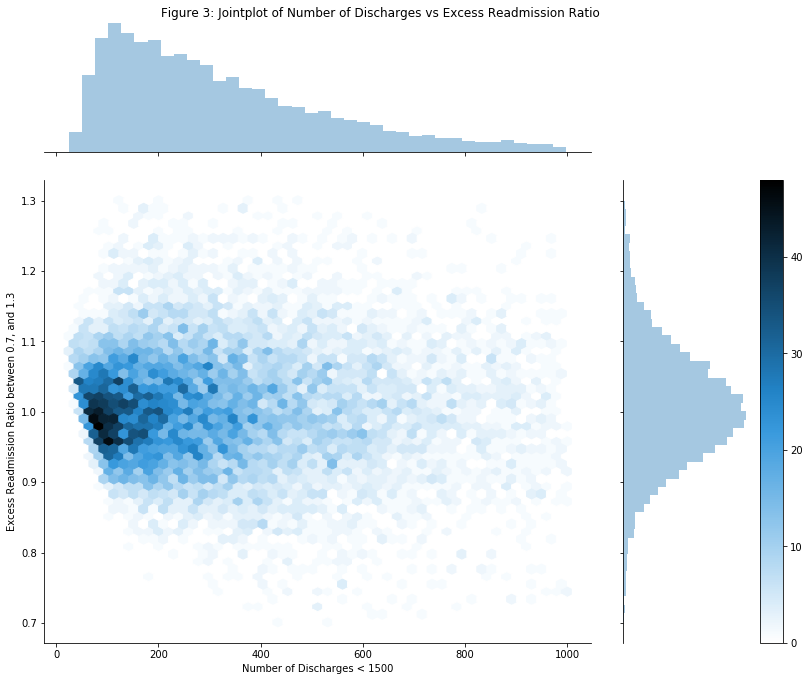

In [160]:
new=data.loc[data.NumberofDischarges<1500]
g=sns.jointplot(x='NumberofDischarges', y='ExcessReadmissionRatio', data=newest, kind="hex",gridsize=50,ratio=3)
fig = plt.gcf()
fig.set_size_inches( 12, 10)
g.fig.suptitle('Figure 3: Jointplot of Number of Discharges vs Excess Readmission Ratio')
g.set_axis_labels('Number of Discharges < 1500','Excess Readmission Ratio between 0.7, and 1.3')
plt.colorbar()
plt.show()

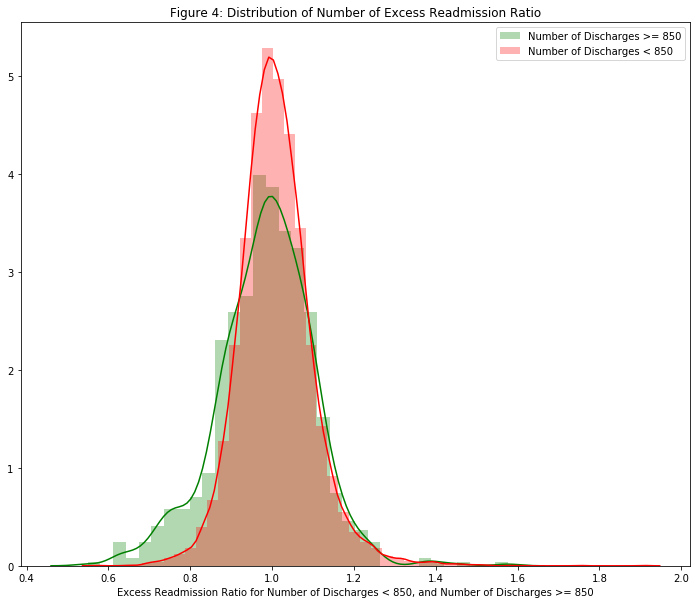

In [162]:
#Shaded green area 
green=data.loc[data.NumberofDischarges>=850]
#unshaded white area
white=data.loc[data.NumberofDischarges<850]
sns.distplot(green.ExcessReadmissionRatio,color='green',hist_kws={'alpha':0.3,'label':'Number of Discharges >= 850'})
sns.distplot(white.ExcessReadmissionRatio,color='red',hist_kws={'alpha':0.3,'label':'Number of Discharges < 850'})
plt.title('Figure 4: Distribution of Number of Excess Readmission Ratio')
plt.xlabel('Excess Readmission Ratio for Number of Discharges < 850, and Number of Discharges >= 850')
plt.legend()
fig = plt.gcf()
fig.set_size_inches( 12, 10)
plt.show()

In [166]:
# Statistical correction check
less=data.loc[data.NumberofDischarges<100] 
more=data.loc[data.NumberofDischarges>1000]
exceed_less=less.loc[less.ExcessReadmissionRatio>1]
exceed_more=more.loc[more.ExcessReadmissionRatio>1]
less_mean=np.mean(less['ExcessReadmissionRatio'])
print('In hospitals/facilities with number of discharges < 100, mean excess readmission rate is ',less_mean)
total_less=len(less)
print('In hospitals/facilities with number of discharges < 100',len(exceed_less)*100/ total_less,
      'have excess readmission rate greater than 1')
total_more=len(more)
more_mean=np.mean(more['ExcessReadmissionRatio'])
print('In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is ',more_mean)
print('In hospitals/facilities with number of discharges < 100',len(exceed_more)*100/ total_more,
      'have excess readmission rate greater than 1')

In hospitals/facilities with number of discharges < 100, mean excess readmission rate is  1.0226183501683506
In hospitals/facilities with number of discharges < 100 63.215488215488215 have excess readmission rate greater than 1
In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is  0.9783354211663071
In hospitals/facilities with number of discharges < 100 44.49244060475162 have excess readmission rate greater than 1


In [22]:
def pearson_r(x, y):
    corr_mat=np.corrcoef(x,y)
    return corr_mat[0,1]
a=data['Number of Discharges'][:-3]
b=data['Excess Readmission Ratio'][:-3]
r=pearson_r(a,b)
print(r)

-0.09309554287590442


In [32]:
# permutation test
perm_replicates = np.empty(10000)

for i in range(10000):
    a_permuted = np.random.permutation(a)
    perm_replicates[i] = pearson_r(a_permuted, b)

p = np.sum(perm_replicates < 0) / len(perm_replicates)
print('p-value: ', p)

p-value:  0.5004


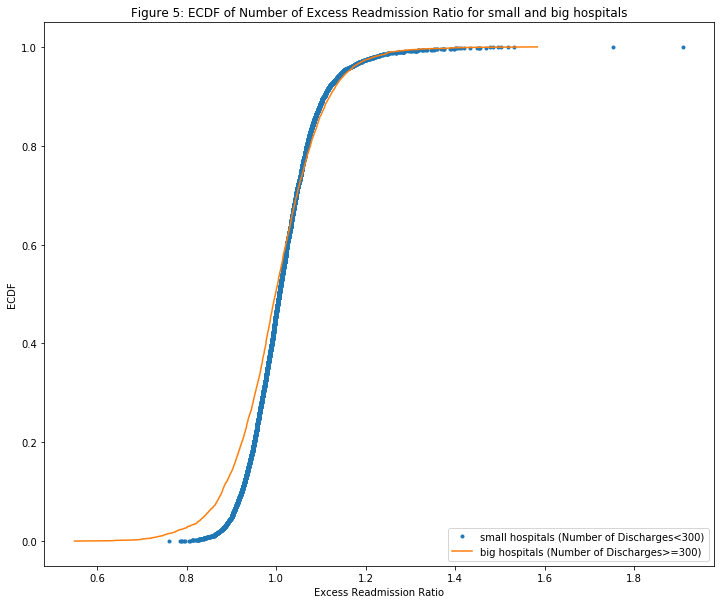

In [165]:
small=data.loc[data.NumberofDischarges<300] 
big=data.loc[data.NumberofDischarges>=300]
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y
x,y=ecdf(small.ExcessReadmissionRatio)
x_b,y_b=ecdf(big.ExcessReadmissionRatio)
_=plt.plot(x,y,marker='.',linestyle='none',label='small hospitals (Number of Discharges<300)')
_=plt.plot(x_b,y_b,label='big hospitals (Number of Discharges>=300)')
_=plt.title('Figure 5: ECDF of Number of Excess Readmission Ratio for small and big hospitals')
_=plt.ylabel('ECDF')
_=plt.xlabel('Excess Readmission Ratio')
fig = plt.gcf()
fig.set_size_inches( 12, 10)
plt.legend(loc='lower right')
plt.show()

## Do you agree with the above analysis and recommendations? Why or why not?

***A.Overall, rate of readmissions is trending down with increasing number of discharges With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red) With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green)***  
    
    According to Figure 5, there is a higher incidence of lower rates of readmissions for big hospitals(Number of Discharges>=300). However, when the excess rate of readmissions exceeds the 1.0 threshold, both of the graphs are same. Therefore I agree that there is an association between the higher number of discharges and lower rates of readmissions.
    
***B.In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1.***
    
    Based on my calculations, the statistics part of the report is correct.
    
***C.There is a significant correlation between hospital capacity (number of discharges) and readmission rates. Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.***
    
    The correlation is around -0.09, which is quite small. Therefore, I don't agree with the report for a 'significant' correlation. However, the p-value is quite big to reject the null hypothesis(0.5> 0.01). So, we can say that there is a very weak correlation between hospital capacity (number of discharges) and readmission rates. Based on this analysis, it is not appropriate to conclude, as small hospitals lack resources to ensure quality care and prevent complications.
    
***D.Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation. Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.***
    
    It is hard to conclude with a comparison between small and big hospitals based on the results. We need further analysis based on other variables to conclude.
    
    H0= There is no difference in the proportions of excess readmission ratio for the small and large hospitals.
    
    H1= There is a difference in the proportions of excess readmission ratio for the small and large hospitals.
    

In [169]:
#Bootstrap test
def permutation_sample(data1, data2):
    data = np.concatenate((data1,data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2
def draw_perm_reps(data_1, data_2, func, size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
    return perm_replicates
def dif_of_mean(data_1,data_2):
    return np.mean(data_1) - np.mean(data_2)
perm_replicates=draw_perm_reps(small.ExcessReadmissionRatio, big.ExcessReadmissionRatio, dif_of_mean, 10000)
emp_mean=dif_of_mean(small.ExcessReadmissionRatio, big.ExcessReadmissionRatio)
p = np.sum(perm_replicates >= emp_mean) / len(perm_replicates)
print('p: ',p)
conf_int = np.percentile(perm_replicates,[2.5,97.5])
print('confidence intervals:',conf_int)
print('Difference of means:',emp_mean)

p:  0.0
confidence intervals: [-0.00330646  0.00337576]
Difference of means: 0.014367364156993245


The p-value is smaller than $\alpha$ = .01. We can reject the null hypothesis. There is a difference in the proportions of excess readmission ratio for the small and large hospitals. Even though the result has a statistical significance, we can't talk about practical significance. The difference between means is quite small.

Before making any recommendation to the clients, I would instead do more analysis with the other variables. 
The scatter plot is a good way to see a correlation between quantitative variables. However, this is a large data set, which means many overlapping points and hardship of interpretations. I think joint plots and ecdf is a better option for this case, such as Figure 2, Figure 3, and Figure 4.
